In [1]:
"""
This script used Kalman filter functions in pkm_utils.py to smooth the predicted keypoints from the combined comNet and postureNet script (mmddyy_posture_2stage_faceNet.npy)
Edited by Sherry on Feb 11, 25
"""
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from pkm_utils import kf_smooth_preds
from scipy.io import loadmat, savemat
import os

In [3]:
''' set paths '''
vid_root = r"Z:/Sherry/acquisition/LVN4_040425_3rdpart/"
pred_file = f'040525_posture_face.npy'
pred_path = f"{vid_root}{pred_file}"
print(pred_path)
os.makedirs(f"{vid_root}behavioral_data/", exist_ok=True)
save_folder = f"{vid_root}behavioral_data/"

Z:/Sherry/acquisition/LVN4_040425_3rdpart/040525_posture_face.npy


### ComNet

In [4]:
''' load the behavioral data '''
results_dict = np.load(pred_path, allow_pickle=True).item()
results = results_dict['results']
results.keys()
com_preds = results['com_preds']
com_conf = results['com_conf'] # the confidence of predictions; shape: (nFrames, 3 body parts)
com_rep_err = results['com_rep_err'] # reprojection errors

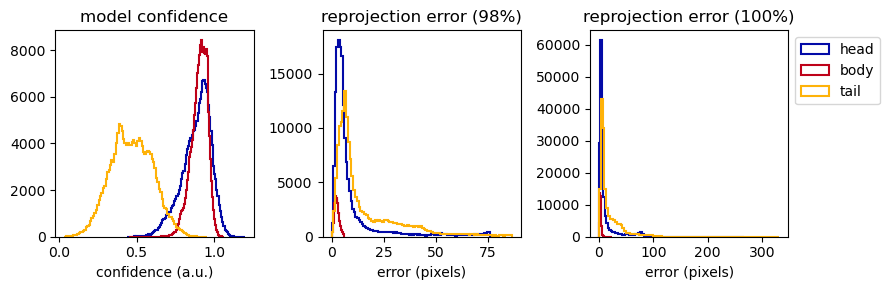

In [5]:
''' Visualise distribution of prediction confidence levels and reprojection errors '''
f, ax = plt.subplots(1, 3, figsize=(9, 3)) # 1 row, 3 colomns, 9 inches wide, 3 inches tall
lw_hist = 1.5

ax[0].hist(com_conf[:, 0], bins=100,
        histtype='step', edgecolor='xkcd:cobalt blue',
        fill=False, lw=lw_hist, label='head') # head
ax[0].hist(com_conf[:, 1], bins=100,
        histtype='step', edgecolor='xkcd:scarlet',
        fill=False, lw=lw_hist, label='body') # body
ax[0].hist(com_conf[:, 2], bins=100,
        histtype='step', edgecolor='xkcd:saffron',
        fill=False, lw=lw_hist, label='tail') # tail
ax[0].set_title('model confidence')
ax[0].set_xlabel('confidence (a.u.)')

pct98 = np.percentile(com_rep_err, 98, axis=0)
ax[1].hist(com_rep_err[com_rep_err[:, 0] < pct98[0], 0],
        bins=100, histtype='step',
        edgecolor='xkcd:cobalt blue',
        fill=False, lw=lw_hist, label='head') # head
ax[1].hist(com_rep_err[com_rep_err[:, 1] < pct98[1], 1],
        bins=100, histtype='step',
        edgecolor='xkcd:scarlet',
        fill=False, lw=lw_hist, label='body') # body
ax[1].hist(com_rep_err[com_rep_err[:, 2] < pct98[2], 2],
        bins=100, histtype='step',
        edgecolor='xkcd:saffron',
        fill=False, lw=lw_hist, label='tail') # tail
ax[1].set_title('reprojection error (98%)')
ax[1].set_xlabel('error (pixels)')

ax[2].hist(com_rep_err[:, 0],
        bins=100, histtype='step',
        edgecolor='xkcd:cobalt blue',
        fill=False, lw=lw_hist, label='head') # head
ax[2].hist(com_rep_err[:, 1],
        bins=100, histtype='step',
        edgecolor='xkcd:scarlet',
        fill=False, lw=lw_hist, label='body') # body
ax[2].hist(com_rep_err[:, 2],
        bins=100, histtype='step',
        edgecolor='xkcd:saffron',
        fill=False, lw=lw_hist, label='tail') # tail
ax[2].legend(loc='upper left',bbox_to_anchor=(1, 1))
ax[2].set_title('reprojection error (100%)')
ax[2].set_xlabel('error (pixels)')

plt.tight_layout()
plt.show()

#### Kalman smoothing

In [6]:
com_pts_3d = results['com_preds'] # shape (n_frames, n_keypoints, xyz)
com_reproj_error = results['com_rep_err']

# smooth over position and velocity for the body and head
com_pos_smooth, com_vel_smooth = kf_smooth_preds(com_pts_3d,
                                         com_reproj_error,
                                         repThresh=18) # IL used 20

Smoothing part #0
Smoothing part #1
Smoothing part #2


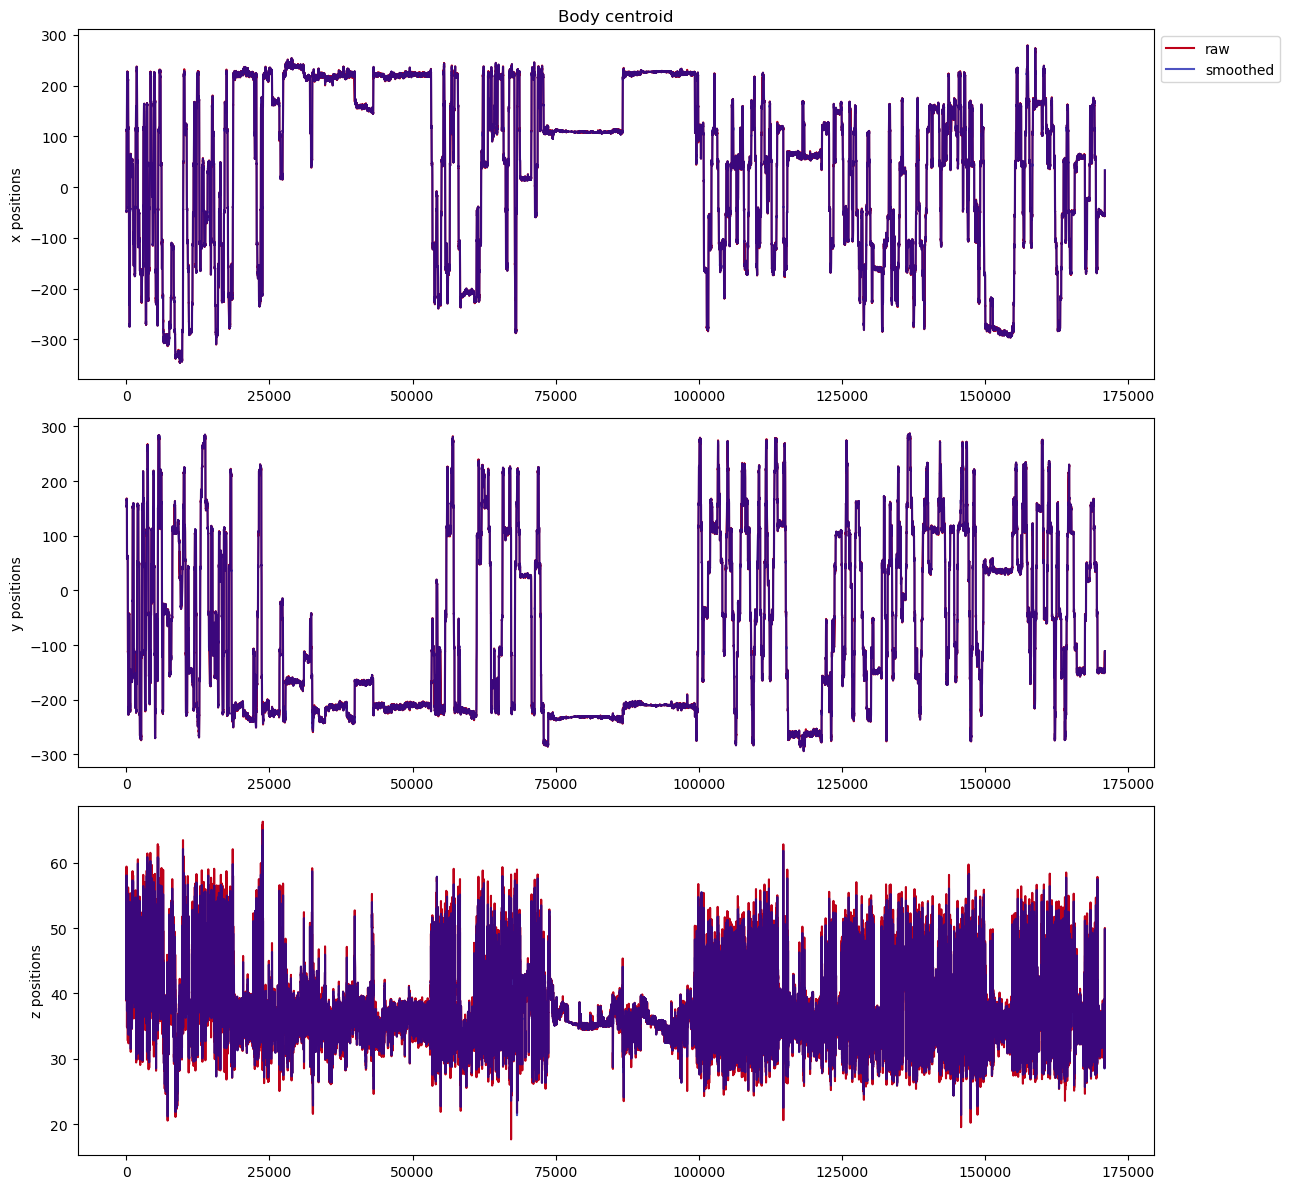

In [7]:
# to plot the x,y,z coordinates of the body centroid of the bird over frames 
f, ax = plt.subplots(3, 1, figsize=(13, 12))
ax[0].plot(com_pts_3d[:, 1, 0], color='xkcd:scarlet', label = 'raw')
ax[0].plot(com_pos_smooth[:, 1, 0], color='xkcd:cobalt blue', alpha= 0.7, label = 'smoothed')
ax[0].set_title('Body centroid')
ax[0].set_ylabel('x positions')
ax[0].legend(loc='upper left',bbox_to_anchor=(1, 1))

ax[1].plot(com_pts_3d[:, 1, 1], color='xkcd:scarlet', label = 'raw')
ax[1].plot(com_pos_smooth[:, 1, 1], color='xkcd:cobalt blue', alpha= 0.7, label = 'smoothed')
ax[1].set_ylabel('y positions')

ax[2].plot(com_pts_3d[:, 1, 2], color='xkcd:scarlet', label = 'raw')
ax[2].plot(com_pos_smooth[:, 1, 2], color='xkcd:cobalt blue', alpha= 0.7, label = 'smoothed')
ax[2].set_ylabel('z positions')
plt.tight_layout()
plt.show()

In [8]:
''' load the arena objects '''
arena_dir = 'Z:/Sherry/camera/arena_alignment/'
arena_items_file = 'arena_items_mm_convexHull_XL.mat'

print('\nGetting arena objects...')
arena_data = loadmat(f'{arena_dir}{arena_items_file}', squeeze_me=True)
arena_data["perches"] = arena_data["perch_w_site"]
arena_data["feeder_perches"] = arena_data["perch_no_site"]


Getting arena objects...


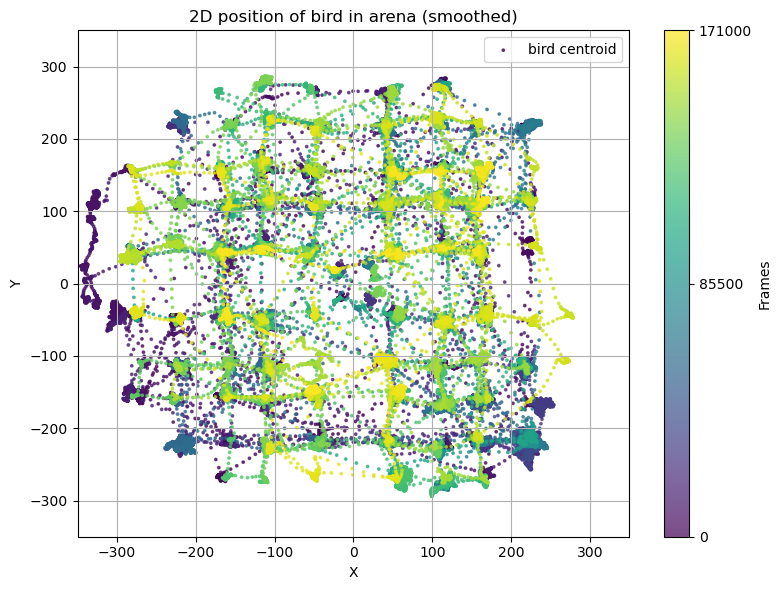

In [9]:
# plot the positions in the 2D arena 
x_coords = com_pos_smooth[:, 1, 0]  # [frames, bodyparts, xyz]
y_coords = com_pos_smooth[:, 1, 1]
z_coords = com_pos_smooth[:, 1, 2]  

plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_coords, y_coords, s = 3, alpha=0.7, label='bird centroid', c=np.linspace(0, len(com_pts_3d), len(com_pts_3d)), cmap='viridis')
plt.xlabel('X')
plt.xlim(-350,350)
plt.ylabel('Y')
plt.ylim(-350,350)
plt.title('2D position of bird in arena (smoothed)')
plt.legend()
colorbar = plt.colorbar(scatter,label='Frames')
colorbar.set_ticks([0, len(com_pts_3d) // 2, len(com_pts_3d)])
plt.grid()
plt.tight_layout()
plt.show()

In [10]:
# save the smoothed position and velocity estimates
# as .npy
save_pos_file = 'com_pos_smooth18_040625.npy'
save_vel_file = 'com_vel_smooth18_040625.npy'
np.save(f'{save_folder}{save_pos_file}', com_pos_smooth)
np.save(f'{save_folder}{save_vel_file}', com_vel_smooth)

# # as .mat
# save_pos_file = 'com_pos_smooth18_021825.mat'
# save_vel_file = 'com_vel_smooth18_021825.mat'
# savemat(f'{save_folder}{save_pos_file}', com_pos_smooth)

In [11]:
# to extract x,y,z positions and velocity of body centroid for place cell analysis 
# Save the smoothed com centroid as .mat file
save_pos_file = 'xyzCom_040625.mat'
savemat(f'{save_folder}{save_pos_file}', {'com_pos_smooth':com_pos_smooth, 'com_vel_smooth': com_vel_smooth})


### PostureNet 

In [12]:
posture_pts_3d = results['posture_preds'] # shape (n_frames, n_keypoints, 3)
posture_conf = results['posture_conf']
posture_rep_err = results['posture_rep_err']

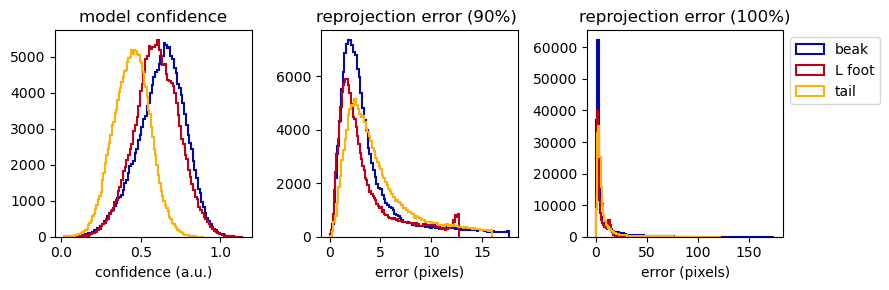

In [13]:
''' Sanity check for postureNet prediction '''
f, ax = plt.subplots(1, 3, figsize=(9, 3))
lw_hist = 1.5

ax[0].hist(posture_conf[:, 0], bins=100,
        histtype='step', edgecolor='xkcd:cobalt blue',
        fill=False, lw=lw_hist, label='beak') # beak
ax[0].hist(posture_conf[:, 10], bins=100,
        histtype='step', edgecolor='xkcd:scarlet',
        fill=False, lw=lw_hist, label='L foot') # left foot
ax[0].hist(posture_conf[:, 2], bins=100,
        histtype='step', edgecolor='xkcd:saffron',
        fill=False, lw=lw_hist, label='tail') # tail
ax[0].set_title('model confidence')
ax[0].set_xlabel('confidence (a.u.)')

pct90 = np.percentile(posture_rep_err, 90, axis=0)
ax[1].hist(posture_rep_err[posture_rep_err[:, 0] < pct90[0], 0],
        bins=100, histtype='step',
        edgecolor='xkcd:cobalt blue',
        fill=False, lw=lw_hist, label='beak') # head
ax[1].hist(posture_rep_err[posture_rep_err[:, 10] < pct90[10], 10],
        bins=100, histtype='step',
        edgecolor='xkcd:scarlet',
        fill=False, lw=lw_hist, label='L foot') # body
ax[1].hist(posture_rep_err[posture_rep_err[:, 2] < pct90[2], 2],
        bins=100, histtype='step',
        edgecolor='xkcd:saffron',
        fill=False, lw=lw_hist, label='tail') # tail
ax[1].set_title('reprojection error (90%) ')
ax[1].set_xlabel('error (pixels)')

ax[2].hist(posture_rep_err[:, 0],
        bins=100, histtype='step',
        edgecolor='xkcd:cobalt blue',
        fill=False, lw=lw_hist, label='beak') # head
ax[2].hist(posture_rep_err[:, 10],
        bins=100, histtype='step',
        edgecolor='xkcd:scarlet',
        fill=False, lw=lw_hist, label='L foot') # body
ax[2].hist(posture_rep_err[:, 2],
        bins=100, histtype='step',
        edgecolor='xkcd:saffron',
        fill=False, lw=lw_hist, label='tail') # tail
ax[2].legend(loc='upper left',bbox_to_anchor=(1, 1))
ax[2].set_title('reprojection error (100%)')
ax[2].set_xlabel('error (pixels)')

plt.tight_layout()
plt.show()

In [14]:
# smooth over position and velocity for the body and head
posture_pos_smooth, posture_vel_smooth = kf_smooth_preds(posture_pts_3d,
                                         posture_rep_err,
                                         repThresh=18) # IL used 20

Smoothing part #0
Smoothing part #1
Smoothing part #2
Smoothing part #3
Smoothing part #4
Smoothing part #5
Smoothing part #6
Smoothing part #7
Smoothing part #8
Smoothing part #9
Smoothing part #10
Smoothing part #11
Smoothing part #12
Smoothing part #13
Smoothing part #14


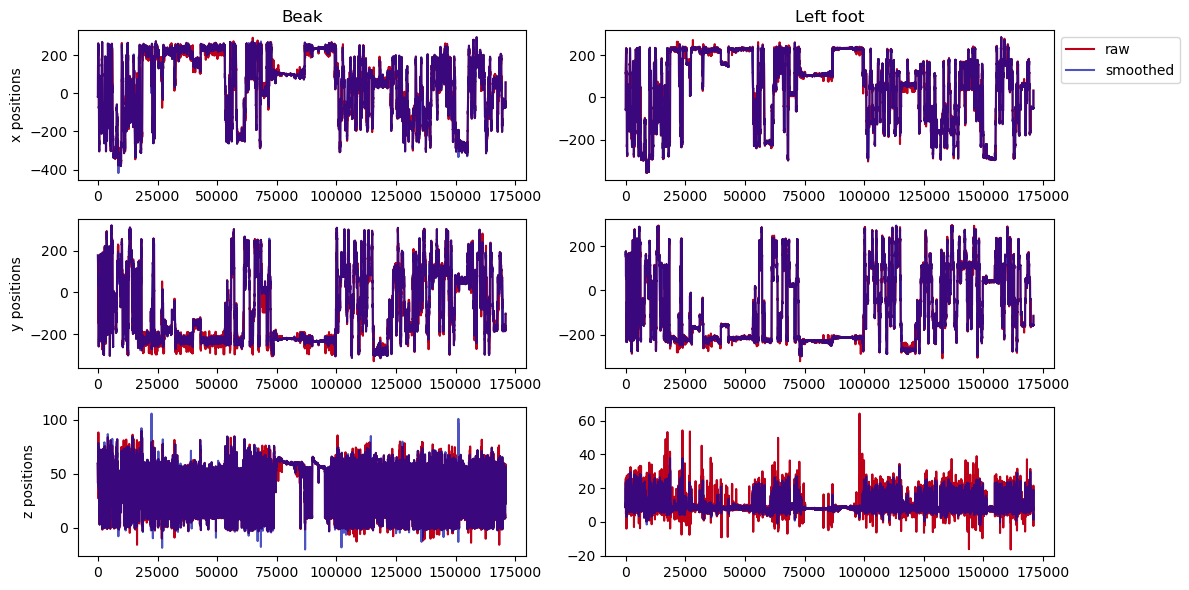

In [15]:
# TODO: check more body parts that the smoothing is acceptable (use a video) 
# to plot the x,y,z coordinates of the beak and left foot of the bird over frames 
# beak 
f, ax = plt.subplots(3, 2, figsize=(12, 6))
ax[0,0].plot(posture_pts_3d[:, 0, 0], color='xkcd:scarlet', label = 'raw')
ax[0,0].plot(posture_pos_smooth[:, 0, 0], color='xkcd:cobalt blue', alpha= 0.7, label = 'smoothed')
# ax[0].set_ylim([-350,350])
ax[0,0].set_title('Beak')
ax[0,0].set_ylabel('x positions')

ax[1,0].plot(posture_pts_3d[:, 0, 1], color='xkcd:scarlet', label = 'raw')
ax[1,0].plot(posture_pos_smooth[:, 0, 1], color='xkcd:cobalt blue', alpha= 0.7, label = 'smoothed')
# ax[1].set_ylim([-350,350])
ax[1,0].set_ylabel('y positions')

ax[2,0].plot(posture_pts_3d[:, 0, 2], color='xkcd:scarlet', label = 'raw')
ax[2,0].plot(posture_pos_smooth[:, 0, 2], color='xkcd:cobalt blue', alpha= 0.7, label = 'smoothed')
# ax[2].set_ylim([0,100])
ax[2,0].set_ylabel('z positions')

# left foot
ax[0,1].plot(posture_pts_3d[:, 10, 0], color='xkcd:scarlet', label = 'raw')
ax[0,1].plot(posture_pos_smooth[:, 10, 0], color='xkcd:cobalt blue', alpha= 0.7, label = 'smoothed')
ax[0,1].set_title('Left foot')
ax[0,1].legend(loc='upper left',bbox_to_anchor=(1, 1))

ax[1,1].plot(posture_pts_3d[:, 10, 1], color='xkcd:scarlet', label = 'raw')
ax[1,1].plot(posture_pos_smooth[:, 10, 1], color='xkcd:cobalt blue', alpha= 0.7, label = 'smoothed')

ax[2,1].plot(posture_pts_3d[:, 10, 2], color='xkcd:scarlet', label = 'raw')
ax[2,1].plot(posture_pos_smooth[:, 10, 2], color='xkcd:cobalt blue', alpha= 0.7, label = 'smoothed')
plt.tight_layout()
plt.show()

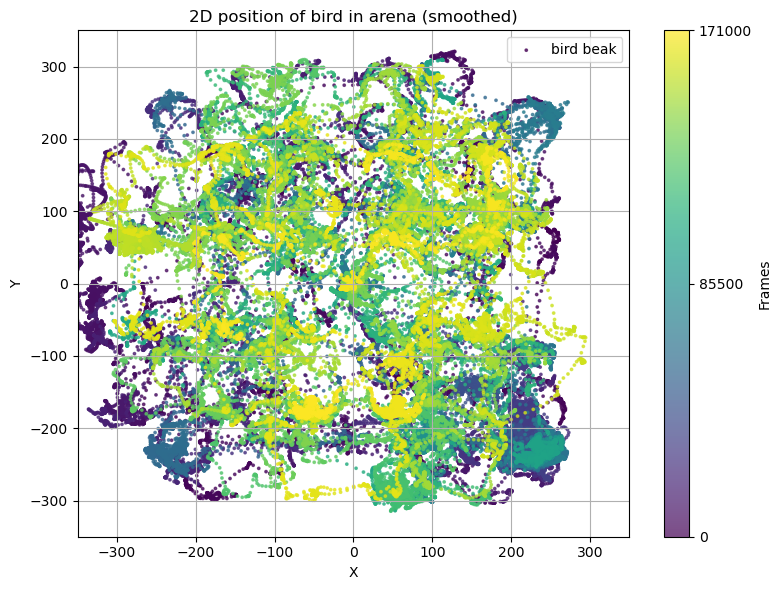

In [16]:
# Visualise in 2D arena (0 = beak)
x_coords = posture_pos_smooth[:, 0, 0]  
y_coords = posture_pos_smooth[:, 0, 1]
z_coords = posture_pos_smooth[:, 0, 2]  

plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_coords, y_coords, s = 3, alpha=0.7, label='bird beak', c=np.linspace(0, len(com_pts_3d), len(com_pts_3d)), cmap='viridis')
plt.xlabel('X')
plt.xlim(-350,350)
plt.ylabel('Y')
plt.ylim(-350,350)
plt.title('2D position of bird in arena (smoothed)')
plt.legend()
colorbar = plt.colorbar(scatter,label='Frames')
colorbar.set_ticks([0, len(com_pts_3d) // 2, len(com_pts_3d)])
plt.grid()
plt.tight_layout()
plt.show()

In [17]:
# as .mat
save_pos_file = 'posture_pos_smooth_040625.mat'
save_vel_file = 'posture_vel_smooth_040625.mat'
savemat(f'{save_folder}{save_pos_file}', {'pos_pts_smooth':posture_pos_smooth, 'pos_vel_smooth': posture_vel_smooth})


In [18]:
results.keys()
savemat(f"{vid_root}040625_posture_face.mat", {'results': results})

In [19]:
# save the smoothed position and velocity estimates
save_pos_file = 'posture_pos_smooth_040625.npy'
save_vel_file = 'posture_vel_smooth_040625.npy'
np.save(f'{save_folder}{save_pos_file}', posture_pos_smooth)
np.save(f'{save_folder}{save_vel_file}', posture_vel_smooth)

In [ ]:
smoothed_com_vel = np.load(r'Z:\Sherry\poseTrackingXL\training_files\raw_acquisition_copy\SLV123_110824_wEphys\behavioral_data\com_vel_smooth.npy')
smoothed_com_vel.shape

# Save the smoothed position and velocity estimates as .mat file
save_vel_file = 'com_vel_smooth.mat'
savemat(f'{save_folder}{save_vel_file}', {'com_vel_smooth': smoothed_com_vel})